# Task 4: Loan Approval Prediction Description 
**Description:**
 * Dataset (Recommended): Loan-Approval-Prediction-Dataset (Kaggle
 * Build a model to predict whether a loan application will be approved
 * Handle missing values and encode categorical features
 * Train a classification model and evaluate performance on imbalanced data
 * Focus on precision, recall, and F1-score
 
 **Tools & Libraries:**
 1. Python
 2. Pandas
 3. Scikit-learn
 
 **Covered Topics**
 * Binary classification |  Imbalanced data

 **Bonus:**
 * Use SMOTE or other techniques to address class imbalance 
 * Try logistic regression vs. decision tree

In [2]:
# Install compatible versions of scikit-learn and imbalanced-learn
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 85.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [9]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [10]:
# Check and install imblearn for SMOTE
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE

In [11]:
# 2. Define output directory
output_dir = './outputs'
os.makedirs(output_dir, exist_ok=True)

# 3. Load dataset
file_path = '/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv'
df = pd.read_csv(file_path)

In [12]:
# 4. Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

# 5. Check dataset info
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())

# 6. Check target distribution
print("\nTarget distribution:\n", df['loan_status'].value_counts())

Dataset shape: (4269, 13)
Columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Missing values:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Target distribution:
 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


In [16]:
# 7. Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# 8. Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove columns only if they exist
for col_to_remove in ['loan_id', 'loan_status']:
    if col_to_remove in categorical_cols:
        categorical_cols.remove(col_to_remove)

# Clean string values (strip spaces)
for col in categorical_cols:
    df[col] = df[col].str.strip()

# Encode with LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [18]:
# 9. Drop loan_id (identifier)
df.drop('loan_id', axis=1, inplace=True, errors='ignore')


# 10. Separate features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# 11. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 12. Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# 13. Check class imbalance
print("\nClass distribution in training set:\n", y_train.value_counts())

# 14. BONUS: Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())


Class distribution in training set:
 loan_status
Approved    2125
Rejected    1290
Name: count, dtype: int64

Class distribution after SMOTE:
 loan_status
Rejected    2125
Approved    2125
Name: count, dtype: int64


In [25]:
# 15. Train Logistic Regression on SMOTE data
lr = LogisticRegression(random_state=42)
lr.fit(X_train_smote, y_train_smote)
lr_pred = lr.predict(X_test)

# 16. Evaluate Logistic Regression
lr_report = classification_report(y_test, lr_pred)
print("\nLogistic Regression Classification Report:\n", lr_report)

# Save Logistic Regression classification report
with open(os.path.join(output_dir, 'lr_classification_report.txt'), 'w') as f:
    f.write(lr_report)



Logistic Regression Classification Report:
               precision    recall  f1-score   support

    Approved       0.95      0.94      0.95       531
    Rejected       0.91      0.91      0.91       323

    accuracy                           0.93       854
   macro avg       0.93      0.93      0.93       854
weighted avg       0.93      0.93      0.93       854



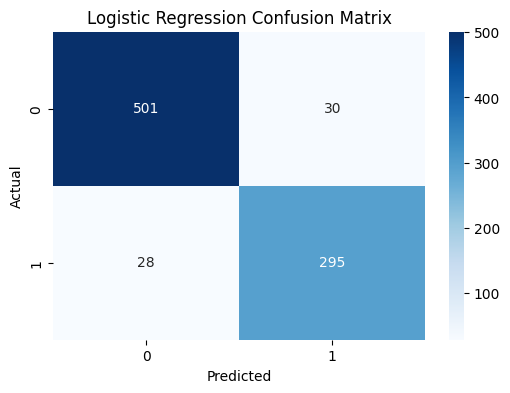

In [21]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(output_dir, 'lr_confusion_matrix.png'))
plt.show()

In [26]:
# 17. Train Decision Tree Classifier on SMOTE data
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_smote, y_train_smote)
dt_pred = dt.predict(X_test)

# 18. Evaluate Decision Tree
dt_report = classification_report(y_test, dt_pred)
print("\nDecision Tree Classification Report:\n", dt_report)

# Save Decision Tree classification report
with open(os.path.join(output_dir, 'dt_classification_report.txt'), 'w') as f:
    f.write(dt_report)



Decision Tree Classification Report:
               precision    recall  f1-score   support

    Approved       0.98      0.98      0.98       531
    Rejected       0.97      0.97      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



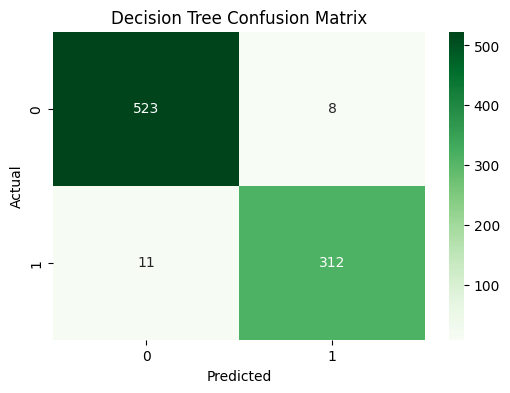

In [23]:
# Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(output_dir, 'dt_confusion_matrix.png'))
plt.show()

In [24]:
# 19. Save processed data and results
pd.DataFrame(X_scaled, columns=X.columns).to_csv(os.path.join(output_dir, 'scaled_features.csv'), index=False)
df.to_csv(os.path.join(output_dir, 'processed_loan_dataset.csv'), index=False)

print("\n✅ All graphs, processed data, and evaluation results saved in 'outputs' directory.")


✅ All graphs, processed data, and evaluation results saved in 'outputs' directory.
